<h1 align=center><font size = 8>Data Science Capstone Project</font></h1>
<h1 align=center><font size = 8>A Comparison of Dallas and Fort Worth</font></h1>

## Introduction
<blockquote>It is often said that Dallas is where the east ends and Fort Worth is where the west begins.  Certainly, it is true that when you think of Fort Worth, you think of pickup trucks and cowboy boots and Billy Bob's at The Stockyards and when you think of Dallas, you think of BMW's and banking and Highland Park.  The question for someone who's company has recently moved to the DFW area, though, is:  is there a difference in the neighborhoods in Fort Worth and Dallas?</blockquote>
<blockquote>This project will use Zillow nighborhood data to see if there are any systematic differences in Dallas vs. Fort Worth nighborhoods using k-means clustering.</blockquote>

We will start by loading the libraries that we need for this project.

In [2]:
try:
    import pandas as pd
    import numpy as np
except:
    !conda install -c anaconda pandas numpy --yes 
    import pandas as pd
    import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
try:
    from geopy.geocoders import Nominatim # to convert address into latitude and longitude
except:
    !conda install -c conda-forge geopy --yes 
    from geopy.geocoders import Nominatim
try:
    import folium # plotting library
except:
    !conda install -c conda-forge folium --yes 
    import folium
from bs4 import BeautifulSoup
import urllib.request
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import geojson
!conda activate geo1
from shapely.geometry import Point, Polygon

In [3]:
!conda activate geo1
from shapely.geometry import Point, Polygon
import geopy.distance

## Data
The geodata used for this project is the Zillow US Neighborhoods dataset.  Zillow makes this data available for free under a creative commons licence.  It can be downloaded at "https://data.opendatasoft.com/explore/dataset/zillow-neighborhoods%40public/export/".
<br>
<br>
We used the export filters and downloaded one geojson file for Fort Worth and a second geojson file for Dallas.  The files contain full geoshape data and has "properties" sections that that contain the city, neighborhood name, regionid, geo_point_2d, county and state.  We parse the files to just load the properties section and append it to a dataframe.  We then split the geo_data_2d entry into Latitude and Longitude columns, dropping any rows where geo_data_2d is NA.


In [4]:
with open('e:/downloads/zillow-neighborhoods-FortWorth.geojson') as json_data:
    fortworth_neighborhood_data = geojson.load(json_data)
with open('e:/downloads/zillow-neighborhoods-Dallas.geojson') as json_data:
    dallas_neighborhood_data = geojson.load(json_data)
print(type(fortworth_neighborhood_data), type(dallas_neighborhood_data))

<class 'geojson.feature.FeatureCollection'> <class 'geojson.feature.FeatureCollection'>


In [5]:
print(type(fortworth_neighborhood_data[0]['geometry']['coordinates'][0]))
print(fortworth_neighborhood_data[0]['geometry']['coordinates'][0])
print(fortworth_neighborhood_data['features'][0])

<class 'list'>
[[-97.428271, 32.645946], [-97.428288, 32.645946], [-97.428367, 32.645944], [-97.428685, 32.645933], [-97.429647, 32.645984], [-97.4302, 32.646044], [-97.430962, 32.646061], [-97.432542, 32.646125], [-97.43244, 32.648147], [-97.428821, 32.648459], [-97.428535, 32.647886], [-97.428396, 32.647557], [-97.428318, 32.647253], [-97.428249, 32.646923], [-97.42824, 32.646541], [-97.428271, 32.645946]]
{"geometry": {"coordinates": [[[-97.428271, 32.645946], [-97.428288, 32.645946], [-97.428367, 32.645944], [-97.428685, 32.645933], [-97.429647, 32.645984], [-97.4302, 32.646044], [-97.430962, 32.646061], [-97.432542, 32.646125], [-97.43244, 32.648147], [-97.428821, 32.648459], [-97.428535, 32.647886], [-97.428396, 32.647557], [-97.428318, 32.647253], [-97.428249, 32.646923], [-97.42824, 32.646541], [-97.428271, 32.645946]]], "type": "Polygon"}, "properties": {"city": "Fort Worth", "county": "Tarrant", "geo_point_2d": [32.64714146486756, -97.43035652827258], "name": "Briercliff", "r

## Append the data to a dataframe

In [6]:
fortworth_neighborhood_data_slice = fortworth_neighborhood_data['features']
df = pd.DataFrame(columns=['city','name','regionid','geo_point_2d','county','state'])
df_coordinates = pd.DataFrame(columns=['coordinates'])
for entry in fortworth_neighborhood_data_slice:
    df = df.append(entry['properties'],ignore_index=True)
    df_coordinates = df_coordinates.append(entry['geometry'],ignore_index=True)
dallas_neighborhood_data_slice = dallas_neighborhood_data['features']
for entry in dallas_neighborhood_data_slice:
    df = df.append(entry['properties'],ignore_index=True)
    df_coordinates = df_coordinates.append(entry['geometry'],ignore_index=True)
df = df.rename(columns={'name': 'Neighborhood'})
df['coordinates']=df_coordinates['coordinates']
df.head()

,city,Neighborhood,regionid,geo_point_2d,county,state,coordinates
0,Fort Worth,Briercliff,422763,"[32.64714146486756, -97.43035652827258]",Tarrant,TX,"[[[-97.428271, 32.645946], [-97.428288, 32.645..."
1,Fort Worth,Fairmount,233172,"[32.724372978687654, -97.33766189387364]",Tarrant,TX,"[[[-97.34377, 32.718042], [-97.34377, 32.71804..."
2,Fort Worth,Willow Creek,207722,"[32.63110091743264, -97.3434603767844]",Tarrant,TX,"[[[-97.348532, 32.634888], [-97.34777, 32.6348..."
3,Fort Worth,Shaw Clarke,422871,"[32.70111450603923, -97.33719612060821]",Tarrant,TX,"[[[-97.33749, 32.70601], [-97.33749, 32.705724..."
4,Fort Worth,Carver Heights,422820,"[32.72505076405124, -97.22932078449055]",Tarrant,TX,"[[[-97.228473, 32.725718], [-97.228222, 32.725..."


Split up geo_point_2d into Latitude and Longitude

In [7]:
print(df.shape)
df = df.dropna(subset=['geo_point_2d'])
print(df.shape)
df2 = pd.DataFrame(df["geo_point_2d"].tolist(), columns=['Latitude','Longitude']) #pd.DataFrame(df['geo_point_2d'].tolist(),index=df.index)
df = pd.concat([df, df2], axis=1)
df.drop(['geo_point_2d'],axis=1,inplace=True)
df.head()

(425, 7)
(425, 7)


,city,Neighborhood,regionid,county,state,coordinates,Latitude,Longitude
0,Fort Worth,Briercliff,422763,Tarrant,TX,"[[[-97.428271, 32.645946], [-97.428288, 32.645...",32.647141,-97.430357
1,Fort Worth,Fairmount,233172,Tarrant,TX,"[[[-97.34377, 32.718042], [-97.34377, 32.71804...",32.724373,-97.337662
2,Fort Worth,Willow Creek,207722,Tarrant,TX,"[[[-97.348532, 32.634888], [-97.34777, 32.6348...",32.631101,-97.343460
3,Fort Worth,Shaw Clarke,422871,Tarrant,TX,"[[[-97.33749, 32.70601], [-97.33749, 32.705724...",32.701115,-97.337196
4,Fort Worth,Carver Heights,422820,Tarrant,TX,"[[[-97.228473, 32.725718], [-97.228222, 32.725...",32.725051,-97.229321


## Load the Zillow Home Value Indices for the neighborhoods

In [8]:
# load zillow home prices
home_prices = pd.read_csv('Neighborhood_Zhvi_AllHomes.csv')
print(home_prices.shape)
df['regionid'] = df['regionid'].astype('int')
print(type(df['regionid'][0]))
home_prices = pd.merge(df,home_prices, left_on='regionid', right_on='RegionID', how='left')
home_prices.head()

(16147, 301)
<class 'numpy.int32'>


,city,Neighborhood,regionid,county,state,coordinates,Latitude,Longitude,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30
0,Fort Worth,Briercliff,422763,Tarrant,TX,"[[[-97.428271, 32.645946], [-97.428288, 32.645...",32.647141,-97.430357,422763.0,16533.0,Briercliff,Neighborhood,TX,TX,Fort Worth,Dallas-Fort Worth-Arlington,Tarrant County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,277005.0,275131.0,273246.0,269484.0,266984.0,264742.0,263505.0,261248.0,259602.0,258853.0,260550.0,262156.0,263092.0,263038.0,263664.0,265627.0,267315.0,269675.0,270991.0,274175.0,27

Extract Dallas-Fort Worth

In [9]:
#dfw = df[df['city'].isin(['Dallas', 'Fort Worth'])]
dfw = df.copy()
dfw.drop(['regionid'],axis=1,inplace=True)
dfw.sort_values(['city','Neighborhood'], inplace=True, ignore_index=True)
print(dfw.shape)
dfw.groupby("city").count()

(425, 7)


,Neighborhood,county,state,coordinates,Latitude,Longitude
city,,,,,,
Carrollton,21,21,21,21,21,21
Dallas,34,34,34,34,34,34
Desoto,6,6,6,6,6,6
Fort Worth,225,225,225,225,225,225
Garland,85,85,85,85,85,85
Irving,18,18,18,18,18,18
Mesquite,4,4,4,4,4,4
Plano,1,1,1,1,1,1
Richardson,31,31,31,31,31,31


# Methodology
##  Visual Inspection:  Create a map of DFW Neighborhoods

In [10]:
# create map - use Arlington for map lat/long
address = 'Arlington, TX'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Arlington are {}, {}.'.format(latitude, longitude))
# using point slightly north to get centering right
latitude =32.791825
longitude = -97.03

The geograpical coordinate of Arlington are 32.701938999999996, -97.10562379033699.


In [11]:
# create map of DFW using latitude and longitude values for Arlington
map_dfw = folium.Map(location=[latitude, longitude], zoom_start=10, control_scale=True)

# add markers to map
for lat, lng, city, neighborhood in zip(dfw['Latitude'], dfw['Longitude'], dfw['city'], dfw['Neighborhood']):
    label = '{}, {}, {}, {}'.format(neighborhood, city, lat, lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dfw)  
map_dfw.save('DFW_Neighborhoods.html')  
map_dfw

# Get Neighborhood Venues

In [262]:
CLIENT_ID = 'YPF4NY2VJMYEMROHWYBYVI11IZKQ0H4EDECKGJR0XDYRWE4M' # your Foursquare ID
CLIENT_SECRET = 'LI202HN0RHIHWIIQQPWSYIPUQE14DLGSNALI21B5XGV4E31Y' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 1000 # limit of number of venues returned by Foursquare API
#radius = 1200 #1600 approx 1 mile, 500 approx .3 mile

In [383]:
# get the bounding distance for the neighborhood polygon stored in coordinates
def neighborhood_radius(coordinates, terse=True):
    while len(coordinates)>0 and len(coordinates)<3:
        coordinates = coordinates[0]            
    try:
        poly = Polygon(coordinates)
    except:
        try:
            poly = Polygon(coordinates[0])
        except:            
            poly = Polygon(coordinates[0][0])     
    b=poly.bounds
    p1 = (b[1],b[0])
    p2 = (b[3],b[2])
    if terse==False:
        print(poly)
        print('Bounds: ',p1,p2)
    return 1000*geopy.distance.vincenty(p1,p2).km

#test the function
hood = 'Frost farms'
#print(dfw_merged.loc[dfw_merged['Neighborhood']==hood])
neighborhood_radius(dfw_merged.loc[dfw_merged['Neighborhood']==hood]['coordinates'].values[0],False)


POLYGON ((-96.882059 32.606332, -96.881939 32.604224, -96.891184 32.604331, -96.89122399999999 32.608866, -96.891104 32.610054, -96.889957 32.610787, -96.889396 32.611348, -96.888583 32.612268, -96.888436 32.612388, -96.88806200000001 32.612668, -96.887675 32.613068, -96.887289 32.613402, -96.88679500000001 32.613682, -96.886194 32.613846, -96.88574300000001 32.613964, -96.88546100000001 32.613989, -96.885307 32.614079, -96.885141 32.614176, -96.884287 32.614496, -96.8835 32.614122, -96.882886 32.614056, -96.88264599999999 32.613375, -96.882299 32.613055, -96.882139 32.612602, -96.882059 32.606332))
Bounds:  (32.604224, -96.891224) (32.614496, -96.881939)


1434.2872361407103

In [295]:
# get the venues using neighborhood_radius() and keep them if they are either in the polygon or within min_radius
def getVenuesInPolygon(names, latitudes, longitudes, polygons,min_radius,logfile):
    LIMIT=100
    max_venues=0
    venues_list=[]
    logfile.write("Venue limit: " + str(LIMIT) + '\n')
    for name, lat, lng, poly in zip(names, latitudes, longitudes, polygons):
        while len(poly)>0 and len(poly)<3:
            poly = poly[0]
        try:
            coordinates = Polygon(poly)
        except:
            try:
                coordinates = Polygon(poly[0])
            except:
                try:
                    coordinates = Polygon(poly[0][0])
                except:
                    print(name," Invalid coordinates: length: ",len(poly),' coordinates: ', poly)
        if coordinates.length==0:
                logfile.write("***** Invalid coordinates: length: " + str(len(poly)) + ' coordinates: \n')
                logfile.write('\t\t' + str(poly) + '\n')                        
        # create the API request URL
        radius = neighborhood_radius(poly)
        current_offset = 0
        if radius<1600:
            radius = 1600
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT,current_offset)
        results = requests.get(url).json()["response"]
        logfile.write(name + '\t' + str(lat) + '\t' + str(lng) + '\n')        
        if len(results)>0:
            
            total_results = results['totalResults']
            logfile.write('\tTotal results\t' + str(total_results) + '\tin radius of\t' + str(radius) + '\n')
            results = results['groups'][0]['items']
            # return only relevant information for each nearby venue
            if total_results>max_venues:
                max_venues = total_results
            venue_count = 0
            for v in results:
                pt = Point([v['venue']['location']['lng'],v['venue']['location']['lat']])
                logfile.write('\t' + v['venue']['name'] + '\tdistance:\t' + str(v['venue']['location']['distance']) )
                if (coordinates.length>0 and pt.within(coordinates)) or v['venue']['location']['distance']<min_radius:
                    venue_count = venue_count + 1
                    venues_list.append([name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],  
                        v['venue']['categories'][0]['name']])
                else:
                    logfile.write('\t** Excluded**')                    
                logfile.write('\n')                 
            while current_offset+len(results)<total_results:
                current_offset = current_offset+len(results)
                url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}'.format(
                    CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT,current_offset)
                results = requests.get(url).json()["response"]
                if len(results)>0:
                    results = results['groups'][0]['items']
                    for v in results:
                        pt = Point([v['venue']['location']['lng'],v['venue']['location']['lat']])
                        logfile.write('\t' + v['venue']['name'] + '\tdistance:\t' + str(v['venue']['location']['distance']) )
                        if (coordinates.length>0 and pt.within(coordinates)) or v['venue']['location']['distance']<min_radius:
                            venue_count = venue_count + 1
                            venues_list.append([name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],  
                                v['venue']['categories'][0]['name']])
                        else:
                            logfile.write('\t** Excluded**')                    
                        logfile.write('\n') 


            print(name, lat, lng, ' venue count ', venue_count)
            logfile.write('Venue Count\t' + str(venue_count) + '\n')       
            if venue_count==0:
                print('\tno venues')
                venues_list.append([name, lat, lng, 'Residential', lat, lng, 'Residential' ])
            
        else:
            print(name, lat, lng,' No groups in results')
            logfile.write('\tNo groups in results\n')
            venues_list.append([name, lat, lng, 'Residential', lat, lng,  'Residential'])
                  
        #except:
        #    print('\tProblem getting info')
    #print('venues_list:  ',venues_list)  
    logfile.write('Max venues\t' + str(max_venues) + '\n')
    nearby_venues = pd.DataFrame(venues_list, columns=['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 
        'Venue Longitude', 'Venue Category']) 
    
    return(nearby_venues)

In [14]:
# original function that was replaced by getVenuesInPolygon()
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        try:    
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            print('\tProblem getting info')
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [299]:
#dfw_venues = getNearbyVenues(names=dfw['Neighborhood'],latitudes=dfw['Latitude'],longitudes=dfw['Longitude'],radius)
#print(dfw['coordinates'].iloc[:5])
#radius=3200
#dfw_venues = getVenuesInPolygon(names=dfw['Neighborhood'].iloc[:5],latitudes=dfw['Latitude'].iloc[:5],longitudes=dfw['Longitude'].iloc[:5],
#    polygons=dfw['coordinates'].iloc[:5])

#get the neighborhood venues
logfile=open('venuelog.csv','w', encoding='utf-8')
dfw_venues = getVenuesInPolygon(dfw['Neighborhood'],dfw['Latitude'],dfw['Longitude'],dfw['coordinates'],800,logfile)
logfile.close()
#print (dfw_venues.head())
print('There are {} unique categories.'.format(len(dfw_venues['Venue Category'].unique())))

Bel Air of Josey Ranch 32.969355914257726 -96.88168631227494  venue count  8
Cambridge Estates 32.988927644291394 -96.91617820375673  venue count  25
Carrollton Heights 32.956817736977484 -96.90127455361676  venue count  10
Carrollton Summertree 32.97278590625278 -96.86834792754553  venue count  1
Carrolton Highlands 32.951421190068444 -96.89745971865148  venue count  11
Hill'n Dale 32.9652324227805 -96.89314077922661  venue count  6
Jackson Arms 32.97657242364724 -96.89296428247056  venue count  28
Mcoy Estates 32.98105765762574 -96.89554645640186  venue count  8
Morningside 32.98840829897419 -96.87152296182454  venue count  3
Nob Hill 32.98963477794778 -96.89570633349281  venue count  20
Oak Tree North 32.98817469682512 -96.86008121492931  venue count  26
Park Terrace 32.96294828979307 -96.9049947817715  venue count  0
	no venues
Parks of Carrollton 32.97653456989962 -96.9022608953078  venue count  12
Parkside Estates 32.97768723189802 -96.87202308761685  venue count  4
Rohton Park 3

In [301]:
dfw_venues.loc[dfw_venues['Venue Category']=='Residential'].count()

Neighborhood              40
Neighborhood Latitude     40
Neighborhood Longitude    40
Venue                     40
Venue Latitude            40
Venue Longitude           40
Venue Category            40
dtype: int64

In [145]:
# spot check categories
dfw_venues.loc[dfw_venues['Venue Category']=='Zoo Exhibit']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
94,Cedar Crest,32.71831,-96.788708,Dallas Zoological Society,32.740868,-96.814195,Zoo Exhibit


In [302]:
# load and merge Venue Groups
venue_groups = pd.read_csv('VenueGroups.csv')
venue_groups.head()
if 'Venue Group' in dfw_venues.columns:
    dfw_venues.drop('Venue Group',axis=1, inplace=True)
dfw_venues = dfw_venues.join(venue_groups.set_index('Venue Category'), on='Venue Category')
dfw_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Group
0,Bel Air of Josey Ranch,32.969356,-96.881686,Braum's Ice Cream & Dairy Store,32.972006,-96.889480,Ice Cream Shop,Fast-Food Venue
1,Bel Air of Josey Ranch,32.969356,-96.881686,The Home Depot,32.973511,-96.886881,Hardware Store,Home Shop
2,Bel Air of Josey Ranch,32.969356,-96.881686,Pizza Hut,32.971590,-96.877311,Pizza Place,Fast-Food Venue
3,Bel Air of Josey Ranch,32.969356,-96.881686,Carrollton Sushi,32.974078,-96.887809,Sushi Restaurant,Asian Cuisine
4,Bel Air of Josey Ranch,32.969356,-96.881686,Chou Cho Sushi,32.974256,-96.887753,Sushi Restaurant,Asian Cuisine


In [303]:
dfw_venues[dfw_venues['Venue Category']=='Discount Store']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Group
143,Oak Tree North,32.988175,-96.860081,Family Dollar,32.988391,-96.852345,Discount Store,Shopping Venues
176,Rohton Park,32.950012,-96.880739,Dollar General,32.952407,-96.888323,Discount Store,Shopping Venues
327,Buckner Terrace,32.785893,-96.702297,Family Dollar,32.791255,-96.698271,Discount Store,Shopping Venues
513,Five Mile Creek,32.696882,-96.831891,Dollar General,32.696537,-96.839050,Discount Store,Shopping Venues
518,Five Mile Creek,32.696882,-96.831891,Family Dollar,32.695911,-96.841080,Discount Store,Shopping Venues
608,Lake Highlands,32.893643,-96.754631,Nordstrom Rack,32.868091,-96.769055,Discount Store,Shopping Venues
985,Wolf Creek,32.658400,-96.846397,Dollar Tree,32.686501,-96.826845,Discount Store,Shopping Venues
1054,Altemesa East,32.646051,-97.282105,Family Dollar,32.649352,-97.283846,Discount Store,Shopping Venues
1156,Bluebonnet Hills,32.700975,-97.362752,Dollar General,32.697377,-97.367980,Discount Store,Shopping Venues
1260,Byers McCart,32.704292,-97.352020,Family Dollar,32.706363,-97.346708,Discount Store,Shopping Venues


In [304]:
# make sure all venue categories have been assigned to venue groups
dfw_venues[dfw_venues['Venue Group']=='']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Group


In [305]:
# subroutine to write formatted dataframe to html
def write_to_html(df, title='', filename='out.html'):
    result = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <title>Capstone Final Project</title>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no">
    <script src="https://code.jquery.com/jquery-3.4.1.slim.min.js" integrity="sha384-J6qa4849blE2+poT4WnyKhv5vZF5SrPo0iEjwBvKU7imGFAV0wwj1yYfoRSJoZ+n" crossorigin="anonymous"></script>
    <script src="https://cdn.jsdelivr.net/npm/popper.js@1.16.0/dist/umd/popper.min.js" integrity="sha384-Q6E9RHvbIyZFJoft+2mJbHaEWldlvI9IOYy5n3zV9zzTtmI3UksdQRVvoxMfooAo" crossorigin="anonymous"></script>
    
    <!-- Bootstrap CSS  v4 -->
    <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.4.1/css/bootstrap.min.css" integrity="sha384-Vkoo8x4CGsO3+Hhxv8T/Q5PaXtkKtu6ug5TOeNV6gBiFeWPGFN9MuhOf23Q9Ifjh" crossorigin="anonymous">
    <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css">
    <script src="https://stackpath.bootstrapcdn.com/bootstrap/4.4.1/js/bootstrap.min.js" integrity="sha384-wfSDF2E50Y2D1uUdj0O3uMBJnjuUD4Ih7YwaYd1iqfktj0Uod8GCExl3Og8ifwB6" crossorigin="anonymous"></script>
    
	<link rel="stylesheet" href="css/style.css">
</head>
<body>
    '''
    result += '<h2 class="text-center"> %s </h2>\n' % title
    #if type(df) == pd.io.formats.style.Styler:
    #    result += df.render()
    #else:
    result += df.to_html(index=False, justify="center",classes="table table-bordered small mx_auto",escape=False)
    result += '''
</body>
</html>
'''
    with open(filename, 'w') as f:
        f.write(result)

In [306]:
# write venue groups to html file
fname = "VenueGroups.html"
title = "Venue Groups"
write_to_html(venue_groups[['Venue Group', 'Venue Category']].sort_values(['Venue Group', 'Venue Category']), title, fname)
#with  open(fname,"w") as file_handle:
#    file_handle.write(venue_groups[['Venue Group', 'Venue Category']].sort_values(['Venue Group', 'Venue Category']).to_html())
#venue_groups.head()
#venue_groups[['Venue Group', 'Venue Category']].sort_values(['Venue Group', 'Venue Category']).head()

In [307]:
print(dfw_venues.groupby('Neighborhood').count())


Neighborhood Latitude  \
Neighborhood                                               
Alamo Heights                                         18   
Alexandra Meadows                                      5   
Almeta,Bonita, Bella Vista                             4   
Altemesa East                                          3   
Apollo Arapaho & Camelot                              13   
Arapaho                                               17   
Arbor Creek                                            2   
Arcadia Park                                          15   
Arlington Heights                                      9   
Arts District                                         37   
Avondale                                              18   
Bal Harbour                                            3   
Basswood Park                                         23   
Basswood Village                                       1   
Bear Creek                                            29   
Beechwood Creek

# Analyze Neighborhoods

In [308]:
# one hot encoding
dfw_onehot = pd.get_dummies(dfw_venues[['Venue Category']], prefix="", prefix_sep="")
# There is Neighborhood in the venue categories, so we drop that column
try:
    del dfw_onehot['Neighborhood']
except:
    print('No venues called Neighborhood')
# add neighborhood column back to dataframe
dfw_onehot['Neighborhood'] = dfw_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dfw_onehot.columns[-1]] + list(dfw_onehot.columns[:-1])
dfw_onehot = dfw_onehot[fixed_columns]
dfw_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Airport Service,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Big Box Store,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Country Dance Club,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Himalayan Restaurant,History Museum,Hobby Shop,Hockey Rink,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Internet Cafe,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Motorsports Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Paper / Office Supplies Store,Park,Pawn Shop,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential,Resort,Restaurant,River,Road,Rock Club,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Bel Air of Josey Ranch,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [309]:
dfw_grouped = dfw_onehot.groupby('Neighborhood').mean().reset_index()
dfw_grouped.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Airport Service,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Big Box Store,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Country Dance Club,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Himalayan Restaurant,History Museum,Hobby Shop,Hockey Rink,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Internet Cafe,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Motorsports Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Paper / Office Supplies Store,Park,Pawn Shop,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential,Resort,Restaurant,River,Road,Rock Club,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Alamo Heights,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.000000,0.0,0.0

# Group most common venues in each neighborhood

In [426]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
top_venue_columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        top_venue_columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        top_venue_columns.append('{}th Most Common Venue'.format(ind+1))
#define similar function for top venues by cluster
def return_most_common_venues_bycluster(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues_by_cluster = 5

# create columns according to number of top venues by cluster
top_venue_columns_bycluster = ['Cluster']
for ind in np.arange(num_top_venues_by_cluster):
    try:
        top_venue_columns_bycluster.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        top_venue_columns_bycluster.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=top_venue_columns)
neighborhoods_venues_sorted['Neighborhood'] = dfw_grouped['Neighborhood']

for ind in np.arange(dfw_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dfw_grouped.iloc[ind, :], num_top_venues)
    for col in range(num_top_venues):
        if dfw_grouped.set_index('Neighborhood').loc[[neighborhoods_venues_sorted.iloc[ind, 0]],[neighborhoods_venues_sorted.iloc[ind, 1+col]]].iloc[0][0] == 0:
            neighborhoods_venues_sorted.iloc[ind, 1+col] = 'NA'
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alamo Heights,Dessert Shop,Fast Food Restaurant,Convenience Store,Sushi Restaurant,Sandwich Place,Burger Joint,Thai Restaurant,Indian Restaurant,Diner,Grocery Store
1,Alexandra Meadows,Park,Donut Shop,Pharmacy,Liquor Store,NA,NA,NA,NA,NA,NA
2,"Almeta,Bonita, Bella Vista",Mexican Restaurant,Market,American Restaurant,NA,NA,NA,NA,NA,NA,NA
3,Altemesa East,Discount Store,Cosmetics Shop,Donut Shop,NA,NA,NA,NA,NA,NA,NA
4,Apollo Arapaho & Camelot,Pizza Place,Coffee Shop,Video Store,Butcher,Bank,Chinese Restaurant,Fast Food Restaurant,Donut Shop,Grocery Store,Sports Bar


In [427]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 6

dfw_grouped_clustering = dfw_grouped.drop('Neighborhood', axis=1)
if 'Cluster' in neighborhoods_venues_sorted.columns:
    neighborhoods_venues_sorted.drop('Cluster',axis=1, inplace=True)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dfw_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster', kmeans.labels_)
dfw_merged = dfw.copy()

# merge merge with venues to add latitude/longitude for each neighborhood
dfw_merged = dfw_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

dfw_merged.head()

,city,Neighborhood,county,state,coordinates,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Carrollton,Bel Air of Josey Ranch,Dallas,TX,"[[[-96.884675, 32.967425], [-96.884703, 32.969...",32.969356,-96.881686,5,Sushi Restaurant,Hardware Store,Ice Cream Shop,Chinese Restaurant,Pizza Place,Gym / Fitness Center,Fast Food Restaurant,NA,NA,NA
1,Carrollton,Cambridge Estates,Dallas,TX,"[[[-96.913294, 32.990296], [-96.910004, 32.990...",32.988928,-96.916178,5,Korean Restaurant,Bubble Tea Shop,Coffee Shop,Bakery,Japanese Restaurant,Locksmith,Financial or Legal Service,Sushi Restaurant,Entertainment Service,Supermarket
2,Carrollton,Carrollton Heights,Dallas,TX,"[[[-96.906652, 32.955414], [-96.906635, 32.956...",32.956818,-96.901275,5,Brewery,History Museum,Southern / Soul Food Restaurant,Park,Donut Shop,Moving Target,Café,Diner,American Restaurant,Burger Joint
3,Carrollton,Carrollton Summertree,Dallas,TX,"[[[-96.864348, 32.97025], [-96.867828, 32.9702...",32.972786,-96.868348,3,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,Carrollton,Carrolton Highlands,Dallas,TX,"[[[-96.890407, 32.95367], [-96.890393, 32.9496...",32.951421,-96.897460,5,Burger Joint,Recreation Center,Grocery Store,Donut Shop,Automotive Shop,Sushi Restaurant,Asian Restaurant,Video Game Store,History Museum,Pizza Place


## check for invalid cluster labels

In [428]:
idx = pd.to_numeric(dfw_merged['Cluster'], errors='coerce').isna()
print('Number of neighborhoods with invalid Clusters: ',len(dfw_merged[idx]), ' out of ',len(dfw_merged.index))
#neighborhoods_venues_sorted[idx]

dfw_merged[idx]

Number of neighborhoods with invalid Clusters:  0  out of  425


,city,Neighborhood,county,state,coordinates,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


## Map clusters--removing rows with invalid cluster labels and converting cluster labels to int before we map them

In [429]:

# first, we have to drop non-numeric clusters and change them to int
dfw_merged = dfw_merged[pd.to_numeric(dfw_merged['Cluster'], errors='coerce').notnull()]
dfw_merged['Cluster'] = dfw_merged['Cluster'].astype('int')
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10,control_scale=True)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow2=['#ffd700','#800080','#ff964f','#ff0000','#008000','#0000ff','#1996f3','#663300','#ffc0cb','#daa520','#ff00ff','#9efd38','#808000','#008080','#800000','#000080'] 
rainbow_text=['yellow','purple','orange','red','green','blue','sky blue','brown','pink','gold','fuchsia','lime','olive','teal','maroon','navy']
#create a dataframe to be used later
color_df = pd.DataFrame(rainbow_text)
color_df.columns = ['Color']
color_df['Cluster'] = color_df.index
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfw_merged['Latitude'], dfw_merged['Longitude'], dfw_merged['Neighborhood'], dfw_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow2[cluster],
        fill=True,
        fill_color=rainbow2[cluster],
        fill_opacity=0.7).add_to(map_clusters)
title_html = '''
            <h3 align="center" style="font-size:20px"><b>DFW Neighborhoods by Venue Category</b></h3>
            '''
map_clusters.get_root().html.add_child(folium.Element(title_html))
map_clusters.save('DFW_by_VenueCategory.html') 
map_clusters

## Examine cluster composition

In [430]:
dfw_merged.groupby('Cluster').count()

,city,Neighborhood,county,state,coordinates,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster,,,,,,,,,,,,,,,,,
0,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
1,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38
2,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
3,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
4,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
5,337,337,337,337,337,337,337,337,337,337,337,337,337,337,337,337,337


In [431]:
# create a dataframe to store information about the clusters
clusters_by_category = pd.DataFrame(dfw_merged.groupby('Cluster')['city'].count())
#cluster_count['CountByGroup']=cluster_count['city']
clusters_by_category.columns = ['Count By Group']
clusters_by_category = clusters_by_category.merge(color_df, left_index=True, right_index=True)
#del cluster_count['Cluster']
# get count by cluster and merge
df = pd.DataFrame(dfw_merged.groupby('Cluster')['city'].count())
#cluster_count['CountByGroup']=cluster_count['city']
df.columns = ['Num']
clusters_by_category = clusters_by_category.merge(df, left_index=True, right_index=True)
clusters_by_category = clusters_by_category[['Cluster','Color', 'Num']]

clusters_by_category

,Cluster,Color,Num
0,0,yellow,18
1,1,purple,38
2,2,orange,12
3,3,red,11
4,4,green,9
5,5,blue,337


In [432]:
def get_top_venues_w_pcnt(row, num_top_venues, first_col):
    df = pd.DataFrame(row.iloc[first_col:].sort_values(ascending=False))
    df.columns = ['Pcnt']
    df['Pcnt'] = pd.Series(["{0:.0f}%".format(val*100) for val in df['Pcnt']],index = df.index)
    df['Venue-Pcnt'] = df.index.map(str) + '-' + df['Pcnt'].map(str)
    df.loc[df.Pcnt == '0%','Venue-Pcnt'] = ''
    #print(df)
    return df['Venue-Pcnt'].values[0:num_top_venues]

In [433]:
# get most common venues by cluster
venues_bycluster = dfw_venues.copy()
venues_bycluster = pd.merge(venues_bycluster, dfw_merged[['Neighborhood', 'Cluster']], on='Neighborhood', how='outer', indicator=False)
venues_bycluster = venues_bycluster[[venues_bycluster.columns[-1]] + list(venues_bycluster.columns[:-1])]
venues_bycluster.head()
# one hot encoding
cluster_onehot = pd.get_dummies(venues_bycluster[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
cluster_onehot['Cluster'] = venues_bycluster['Cluster'] 
# move neighborhood column to the first column
fixed_columns = [cluster_onehot.columns[-1]] + list(cluster_onehot.columns[:-1])
cluster_onehot = cluster_onehot[fixed_columns]
group_bycluster = cluster_onehot.groupby('Cluster').mean().reset_index()
cluster_venues_sorted = pd.DataFrame(columns=top_venue_columns_bycluster)
cluster_venues_sorted['Cluster'] = group_bycluster['Cluster']
for ind in np.arange(group_bycluster.shape[0]):
    cluster_venues_sorted.iloc[ind, 1:] = return_most_common_venues_bycluster(group_bycluster.iloc[ind, :], num_top_venues_by_cluster)
    for col in range(num_top_venues_by_cluster):
        if group_bycluster.set_index('Cluster').loc[[cluster_venues_sorted.iloc[ind, 0]],[cluster_venues_sorted.iloc[ind, 1+col]]].iloc[0][0] == 0:
            cluster_venues_sorted.iloc[ind, 1+col] = ''
#group_bycluster.head()
#cluster_venues_sorted.head(15)


In [434]:
# get the average percentage of the groups by cluster
dfw_clustering_bycategory =dfw_grouped.copy()
# add clustering labels
dfw_clustering_bycategory.insert(0, 'Cluster', kmeans.labels_)
dfw_clustering_bycategory = dfw_clustering_bycategory.groupby('Cluster').mean()
average_venues_by_cluster = pd.DataFrame(columns=top_venue_columns_bycluster)
average_venues_by_cluster['Cluster'] = group_bycluster['Cluster']
# get top groups
for ind in np.arange(dfw_clustering_bycategory.shape[0]):
    average_venues_by_cluster.iloc[ind, 1:] = get_top_venues_w_pcnt(dfw_clustering_bycategory.iloc[ind, :], num_top_venues_by_cluster,1)
#average_venues_by_cluster

In [435]:
# join tables
clusters_by_category = clusters_by_category.join(average_venues_by_cluster.set_index('Cluster'), on='Cluster')
# add link to cluster listings and save file
clusters_by_category['List'] = clusters_by_category.apply(lambda row: '<a href="Cluster-ByCategory-' + str(row.Cluster) + '-' + str(kclusters) + '.html"'  + 'target="_blank">Cluster ' + str(row.Cluster) + '</a>',axis=1)
fname = "Clusters_By_Category.html"
title = 'Clusters By Category'
write_to_html(clusters_by_category,title,fname)
#with  open(fname,"w") as file_handle:
#        file_handle.write(clusters_by_category.to_html(index=False, justify="center",classes="table table-bordered",escape=False))


In [436]:
clusters_by_category

,Cluster,Color,Num,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,List
0,0,yellow,18,Convenience Store-62%,Video Store-5%,Intersection-5%,Mexican Restaurant-3%,Basketball Court-3%,"<a href=""Cluster-ByCategory-0-6.html""target=""_..."
1,1,purple,38,Residential-100%,,,,,"<a href=""Cluster-ByCategory-1-6.html""target=""_..."
2,2,orange,12,Discount Store-67%,Fried Chicken Joint-9%,Grocery Store-4%,Convenience Store-4%,Gym-4%,"<a href=""Cluster-ByCategory-2-6.html""target=""_..."
3,3,red,11,Park-77%,Golf Course-6%,American Restaurant-5%,Intersection-3%,Pharmacy-2%,"<a href=""Cluster-ByCategory-3-6.html""target=""_..."
4,4,green,9,Golf Course-89%,Other Repair Shop-6%,Hardware Store-6%,,,"<a href=""Cluster-ByCategory-4-6.html""target=""_..."
5,5,blue,337,Fast Food Restaurant-6%,Mexican Restaurant-5%,Pizza Place-4%,Discount Store-3%,Convenience Store-3%,"<a href=""Cluster-ByCategory-5-6.html""target=""_..."


In [437]:
# write clusters to html files
for f in range(kclusters):
    fname = "Cluster-ByCategory-" + str(f) + "-" + str(kclusters) + ".html"
    title = "Cluster By Category: " +str(f) + " of " + str(kclusters)
    fst_venue_col = 7
    cluster_df = dfw_merged.loc[dfw_merged['Cluster'] == f, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])
    write_to_html(cluster_df, title, fname)
    #with  open(fname,"w") as file_handle:
    #    file_handle.write(cluster_df.to_html())

In [438]:
dfw_merged.loc[dfw_merged['Neighborhood']=='Wolf Creek']

,city,Neighborhood,county,state,coordinates,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
54,Dallas,Wolf Creek,Dallas,TX,"[[[-96.823164, 32.654073], [-96.823078, 32.641...",32.6584,-96.846397,5,Fast Food Restaurant,BBQ Joint,Convenience Store,Fried Chicken Joint,Salon / Barbershop,General Entertainment,Paper / Office Supplies Store,Mexican Restaurant,Discount Store,Hardware Store


In [439]:
dfw_merged.loc[dfw_merged['Cluster'] == 0, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
68,Fort Worth,Basswood Village,0,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
80,Fort Worth,Brittany Place,0,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
93,Fort Worth,Caville,0,Convenience Store,Shopping Mall,NA,NA,NA,NA,NA,NA,NA,NA
134,Fort Worth,Garden Acres,0,Sandwich Place,Truck Stop,Convenience Store,NA,NA,NA,NA,NA,NA,NA
138,Fort Worth,Greenfield Acres,0,Convenience Store,Gym / Fitness Center,Lake,NA,NA,NA,NA,NA,NA,NA
154,Fort Worth,Historic Southside,0,Fast Food Restaurant,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA
172,Fort Worth,Marine Creek Hills,0,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
173,Fort Worth,Marine Creek Ranch,0,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
191,Fort Worth,Northbrook,0,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
203,Fort Worth,Parkview Hills,0,Convenience Store,Video Store,NA,NA,NA,NA,NA,NA,NA,NA


In [440]:
dfw_merged.loc[dfw_merged['Cluster'] == 1, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Carrollton,Park Terrace,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
57,Desoto,Frost farms,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
59,Desoto,Meadowbrook Estates,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
79,Fort Worth,Briercliff,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
96,Fort Worth,Chadwick Farms,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
104,Fort Worth,Cookes Meadow,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
105,Fort Worth,Coventry,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
114,Fort Worth,East Lake Worth,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
122,Fort Worth,Fairhaven,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
146,Fort Worth,Harriet Creek Ranch,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [441]:
dfw_merged.loc[dfw_merged['Cluster'] == 2, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
107,Fort Worth,Crawford Farms,2,Discount Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
116,Fort Worth,Eastland,2,Discount Store,Fried Chicken Joint,Pizza Place,Pharmacy,NA,NA,NA,NA,NA,NA
117,Fort Worth,Eastwood Pleasant Glade,2,Discount Store,Fried Chicken Joint,NA,NA,NA,NA,NA,NA,NA,NA
135,Fort Worth,Gardens of Westridge,2,Discount Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
141,Fort Worth,Hamlet,2,Discount Store,Doctor's Office,Baseball Field,NA,NA,NA,NA,NA,NA,NA
193,Fort Worth,Oakridge Terrace,2,Discount Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
211,Fort Worth,Ridglea,2,Discount Store,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA
238,Fort Worth,Southgate,2,Discount Store,Gym,NA,NA,NA,NA,NA,NA,NA,NA
243,Fort Worth,Stop Six,2,Discount Store,Grocery Store,NA,NA,NA,NA,NA,NA,NA,NA
244,Fort Worth,Stop Six Sunrise Edition,2,Discount Store,Fried Chicken Joint,NA,NA,NA,NA,NA,NA,NA,NA


In [442]:
dfw_merged.loc[dfw_merged['Cluster'] == 3, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Carrollton,Carrollton Summertree,3,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
62,Fort Worth,Alexandra Meadows,3,Park,Donut Shop,Pharmacy,Liquor Store,NA,NA,NA,NA,NA,NA
100,Fort Worth,Chisholm Ridge,3,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
121,Fort Worth,FW Vista West,3,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
157,Fort Worth,Hulen Bend Estates,3,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
207,Fort Worth,Quail Ridge,3,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
251,Fort Worth,Tanglewood,3,Park,American Restaurant,NA,NA,NA,NA,NA,NA,NA,NA
270,Fort Worth,Vista Ridge,3,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
307,Garland,Crystal Falls,3,Park,Intersection,NA,NA,NA,NA,NA,NA,NA,NA
321,Garland,Greens,3,Park,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA


In [443]:
dfw_merged.loc[dfw_merged['Cluster'] == 4, dfw_merged.columns[[0,1] + list(range(6, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
69,Fort Worth,Beechwood Creek,-97.297091,4,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
71,Fort Worth,Bently Village,-97.161811,4,Hardware Store,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA
102,Fort Worth,Colonial Hills,-97.371822,4,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
170,Fort Worth,Lost Creek,-97.524046,4,Other Repair Shop,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA
179,Fort Worth,Mira Vista,-97.437491,4,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
299,Garland,Club Creek,-96.597038,4,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
324,Garland,Hills of Firewheel,-96.636684,4,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
339,Garland,Oakridge,-96.673445,4,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
350,Garland,Retreat at Firewheel,-96.631646,4,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [444]:
dfw_merged.loc[dfw_merged['Cluster'] == 5, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Carrollton,Bel Air of Josey Ranch,5,Sushi Restaurant,Hardware Store,Ice Cream Shop,Chinese Restaurant,Pizza Place,Gym / Fitness Center,Fast Food Restaurant,NA,NA,NA
1,Carrollton,Cambridge Estates,5,Korean Restaurant,Bubble Tea Shop,Coffee Shop,Bakery,Japanese Restaurant,Locksmith,Financial or Legal Service,Sushi Restaurant,Entertainment Service,Supermarket
2,Carrollton,Carrollton Heights,5,Brewery,History Museum,Southern / Soul Food Restaurant,Park,Donut Shop,Moving Target,Café,Diner,American Restaurant,Burger Joint
4,Carrollton,Carrolton Highlands,5,Burger Joint,Recreation Center,Grocery Store,Donut Shop,Automotive Shop,Sushi Restaurant,Asian Restaurant,Video Game Store,History Museum,Pizza Place
5,Carrollton,Hill'n Dale,5,BBQ Joint,Baseball Field,Trail,Fast Food Restaurant,Water Park,Bookstore,NA,NA,NA,NA
6,Carrollton,Jackson Arms,5,Pizza Place,Pharmacy,Convenience Store,Ice Cream Shop,Sandwich Place,Fast Food Restaurant,Sushi Restaurant,Juice Bar,Park,Paper / Office Supplies Store
7,Carrollton,Mcoy Estates,5,Sandwich Place,Hobby Shop,Coffee Shop,Miscellaneous Shop,Trail,Mexican Restaurant,Donut Shop,Park,NA,NA
8,Carrollton,Morningside,5,Gas Station,Storage Facility,Grocery Store,Bank,Discount Store,Fried Chicken Joint,Ice Cream Shop,NA,NA,NA
9,Carrollton,Nob Hill,5,Cosmetics Shop,Clothing Store,Sandwich Place,South American Restaurant,Video Game Store,Shoe Store,Cuban Restaurant,Spa,Supermarket,Supplement Shop
10,Carrollton,Oak Tree North,5,Mexican Restaurant,Fast Food Restaurant,Smoothie Shop,Bar,Latin American Restaurant,Storage Facility,South American Restaurant,Pet Store,Fried Chicken Joint,Pool


In [445]:
dfw_merged.loc[dfw_merged['Cluster'] == 6, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [446]:
dfw_merged.loc[dfw_merged['Cluster'] == 7, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


## Analyze Neighborhoods by Venue Group

In [471]:
# one hot encoding
dfw_onehot = pd.get_dummies(dfw_venues[['Venue Group']], prefix="", prefix_sep="")
# There is Neighborhood in the venue categories, so we drop that column
try:
    del dfw_onehot['Neighborhood']
except:
    print('No venues called Neighborhood')
# add neighborhood column back to dataframe
dfw_onehot['Neighborhood'] = dfw_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dfw_onehot.columns[-1]] + list(dfw_onehot.columns[:-1])
dfw_onehot = dfw_onehot[fixed_columns]
dfw_grouped2 = dfw_onehot.groupby('Neighborhood').mean().reset_index()
neighborhoods_venues_sorted = pd.DataFrame(columns=top_venue_columns)
neighborhoods_venues_sorted['Neighborhood'] = dfw_grouped2['Neighborhood']

for ind in np.arange(dfw_grouped2.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dfw_grouped2.iloc[ind, :], num_top_venues)
    for col in range(num_top_venues):
        if dfw_grouped2.set_index('Neighborhood').loc[[neighborhoods_venues_sorted.iloc[ind, 0]],[neighborhoods_venues_sorted.iloc[ind, 1+col]]].iloc[0][0] == 0:
            neighborhoods_venues_sorted.iloc[ind, 1+col] = 'NA'
# cluster analysis
dfw_grouped_clustering_bygroup = dfw_grouped2.drop('Neighborhood', axis=1)
if 'Cluster' in neighborhoods_venues_sorted.columns:
    neighborhoods_venues_sorted.drop('Cluster',axis=1, inplace=True)
# run k-means clustering
kclusters2 = 15
kmeans = KMeans(n_clusters=kclusters2, random_state=0).fit(dfw_grouped_clustering_bygroup)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster', kmeans.labels_)
dfw_merged_bygroup = dfw.copy()

# merge dfw data to add latitude/longitude for each neighborhood
dfw_merged_bygroup = dfw_merged_bygroup.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

idx = pd.to_numeric(dfw_merged_bygroup['Cluster'], errors='coerce').isna()
print('Number of neighborhoods with invalid Clusters: ',len(dfw_merged_bygroup[idx]), ' out of ',len(dfw_merged_bygroup.index))
print(neighborhoods_venues_sorted[idx])



No venues called Neighborhood
Number of neighborhoods with invalid Clusters:  0  out of  425
Empty DataFrame
Columns: [Cluster, Neighborhood, 1st Most Common Venue, 2nd Most Common Venue, 3rd Most Common Venue, 4th Most Common Venue, 5th Most Common Venue, 6th Most Common Venue, 7th Most Common Venue, 8th Most Common Venue, 9th Most Common Venue, 10th Most Common Venue]
Index: []


In [472]:
# Create the map
# first, we have to drop non-numeric clusters and change them to int
dfw_merged_bygroup = dfw_merged_bygroup[pd.to_numeric(dfw_merged_bygroup['Cluster'], errors='coerce').notnull()]
dfw_merged_bygroup['Cluster'] = dfw_merged_bygroup['Cluster'].astype('int')
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=10, control_scale=True)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfw_merged_bygroup['Latitude'], dfw_merged_bygroup['Longitude'], dfw_merged_bygroup['Neighborhood'], dfw_merged_bygroup['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow2[cluster],
        fill=True,
        fill_color=rainbow2[cluster],
        fill_opacity=0.7).add_to(map_clusters2)
title_html = '''
            <h3 align="center" style="font-size:20px"><b>DFW Neighborhoods by Venue Group - ''' + str(kclusters2) + ''' Clusters</b></h3>
            '''
map_clusters2.get_root().html.add_child(folium.Element(title_html))

map_clusters2.save('DFW_by_VenueGroup-' + str(kclusters2) + '.html')      
map_clusters2

## Examine cluster composition

In [473]:
# create a dataframe to store information about the clusters
clusters_by_group = pd.DataFrame(dfw_merged_bygroup.groupby('Cluster')['city'].count())
#cluster_count['CountByGroup']=cluster_count['city']
clusters_by_group.columns = ['Count By Group']
clusters_by_group = clusters_by_group.merge(color_df, left_index=True, right_index=True)
#del cluster_count['Cluster']
# get count by cluster and merge
df = pd.DataFrame(dfw_merged_bygroup.groupby('Cluster')['city'].count())
#cluster_count['CountByGroup']=cluster_count['city']
df.columns = ['Num']
clusters_by_group = clusters_by_group.merge(df, left_index=True, right_index=True)
clusters_by_group = clusters_by_group[['Cluster','Color', 'Num']]

clusters_by_group


,Cluster,Color,Num
0,0,yellow,9
1,1,purple,120
2,2,orange,38
3,3,red,10
4,4,green,8
5,5,blue,9
6,6,sky blue,19
7,7,brown,14
8,8,pink,7
9,9,gold,4


In [474]:
# get most common venues by cluster
venues_bycluster = dfw_venues.copy()
venues_bycluster = pd.merge(venues_bycluster, dfw_merged_bygroup[['Neighborhood', 'Cluster']], on='Neighborhood', how='outer', indicator=False)
venues_bycluster = venues_bycluster[[venues_bycluster.columns[-1]] + list(venues_bycluster.columns[:-1])]
venues_bycluster.head()
# one hot encoding
cluster_onehot = pd.get_dummies(venues_bycluster[['Venue Group']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
cluster_onehot['Cluster'] = venues_bycluster['Cluster'] 
# move neighborhood column to the first column
fixed_columns = [cluster_onehot.columns[-1]] + list(cluster_onehot.columns[:-1])
cluster_onehot = cluster_onehot[fixed_columns]
group_bycluster = cluster_onehot.groupby('Cluster').mean().reset_index()
cluster_venues_sorted = pd.DataFrame(columns=top_venue_columns_bycluster)
cluster_venues_sorted['Cluster'] = group_bycluster['Cluster']
for ind in np.arange(group_bycluster.shape[0]):
    cluster_venues_sorted.iloc[ind, 1:] = return_most_common_venues_bycluster(group_bycluster.iloc[ind, :], num_top_venues_by_cluster)
    for col in range(num_top_venues_by_cluster):
        if group_bycluster.set_index('Cluster').loc[[cluster_venues_sorted.iloc[ind, 0]],[cluster_venues_sorted.iloc[ind, 1+col]]].iloc[0][0] == 0:
            cluster_venues_sorted.iloc[ind, 1+col] = ''
#group_bycluster.head()
cluster_venues_sorted.head(15)


,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Asian Cuisine,Fast-Food Venue,Grocery Store,Mexican Cuisine,Bubble Tea Shop
1,1,Fast-Food Venue,Asian Cuisine,Shopping Venues,Mexican Cuisine,American Cuisine
2,2,Residential,,,,
3,3,Golf Course,Home Shop,Park,Home Service,
4,4,Park,American Cuisine,Intersection,,
5,5,Convenience Store,Video Store,Gym,Outdoor Destination,Intersection
6,6,Shopping Venues,Fast-Food Venue,Gym,Grocery Store,Convenience Store
7,7,Fast-Food Venue,Convenience Store,Gas Station,Shopping Venues,Athletic Venue
8,8,Outdoor Destination,Intersection,,,
9,9,Home Service,Home Shop,Shopping Venues,,


In [475]:
for ind in np.arange(group_bycluster.shape[0]):
    cluster_venues_sorted.iloc[ind, 1:] = get_top_venues_w_pcnt(group_bycluster.iloc[ind, :], num_top_venues_by_cluster,2)
cluster_venues_sorted

,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Asian Cuisine-45%,Fast-Food Venue-20%,Grocery Store-10%,Mexican Cuisine-3%,Bubble Tea Shop-3%
1,1,Fast-Food Venue-22%,Asian Cuisine-7%,Shopping Venues-7%,Mexican Cuisine-7%,American Cuisine-6%
2,2,Residential-100%,,,,
3,3,Golf Course-77%,Home Shop-8%,Park-8%,Home Service-8%,
4,4,Park-82%,American Cuisine-9%,Intersection-9%,,
5,5,Convenience Store-71%,Video Store-7%,Gym-7%,Outdoor Destination-7%,Intersection-7%
6,6,Shopping Venues-50%,Fast-Food Venue-15%,Gym-4%,Grocery Store-4%,Convenience Store-4%
7,7,Fast-Food Venue-77%,Convenience Store-6%,Gas Station-6%,Shopping Venues-6%,Athletic Venue-3%
8,8,Outdoor Destination-78%,Intersection-11%,,,
9,9,Home Service-71%,Home Shop-14%,Shopping Venues-14%,,


In [476]:
# get the average percentage of the groups by cluster
dfw_clustering_bygroup =dfw_grouped2.copy()
# add clustering labels
dfw_clustering_bygroup.insert(0, 'Cluster', kmeans.labels_)
dfw_clustering_bygroup = dfw_clustering_bygroup.groupby('Cluster').mean()
average_venues_by_cluster = pd.DataFrame(columns=top_venue_columns_bycluster)
average_venues_by_cluster['Cluster'] = group_bycluster['Cluster']
# get top groups
for ind in np.arange(dfw_clustering_bygroup.shape[0]):
    average_venues_by_cluster.iloc[ind, 1:] = get_top_venues_w_pcnt(dfw_clustering_bygroup.iloc[ind, :], num_top_venues_by_cluster,1)
average_venues_by_cluster

,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Asian Cuisine-39%,Grocery Store-29%,Fast-Food Venue-9%,Mexican Cuisine-6%,Light Rail Station-6%
1,1,Fast-Food Venue-22%,Shopping Venues-8%,American Cuisine-6%,Mexican Cuisine-6%,Asian Cuisine-5%
2,2,Residential-100%,,,,
3,3,Golf Course-85%,Home Shop-5%,Park-5%,Home Service-5%,
4,4,Park-90%,American Cuisine-6%,Intersection-4%,,
5,5,Convenience Store-83%,Video Store-6%,Intersection-6%,Gym-3%,Outdoor Destination-3%
6,6,Shopping Venues-60%,Fast-Food Venue-15%,Convenience Store-6%,Gym-6%,Grocery Store-4%
7,7,Fast-Food Venue-88%,Gas Station-3%,Shopping Venues-3%,Athletic Venue-2%,Convenience Store-2%
8,8,Outdoor Destination-86%,Intersection-7%,,,
9,9,Home Service-88%,Home Shop-6%,Shopping Venues-6%,,


In [477]:
# add link to cluster listings and save file
clusters_by_group = clusters_by_group.join(average_venues_by_cluster.set_index('Cluster'), on='Cluster')
#clusters_by_group = average_venues_by_cluster # comment out to use average across clusters instead of average by cluster
clusters_by_group['List'] = clusters_by_group.apply(lambda row: '<a href="Cluster-ByGroup-' + str(row.Cluster) + '-' + str(kclusters2) + '.html"'  + 'target="_blank">Cluster ' + str(row.Cluster) + '</a>',axis=1)
fname = "Clusters_By_Group-" + str(kclusters2) + ".html"
title = "Clusters By Group, k=" + str(kclusters2)
write_to_html(clusters_by_group,title,fname)


In [478]:
clusters_by_group

,Cluster,Color,Num,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,List
0,0,yellow,9,Asian Cuisine-39%,Grocery Store-29%,Fast-Food Venue-9%,Mexican Cuisine-6%,Light Rail Station-6%,"<a href=""Cluster-ByGroup-0-15.html""target=""_bl..."
1,1,purple,120,Fast-Food Venue-22%,Shopping Venues-8%,American Cuisine-6%,Mexican Cuisine-6%,Asian Cuisine-5%,"<a href=""Cluster-ByGroup-1-15.html""target=""_bl..."
2,2,orange,38,Residential-100%,,,,,"<a href=""Cluster-ByGroup-2-15.html""target=""_bl..."
3,3,red,10,Golf Course-85%,Home Shop-5%,Park-5%,Home Service-5%,,"<a href=""Cluster-ByGroup-3-15.html""target=""_bl..."
4,4,green,8,Park-90%,American Cuisine-6%,Intersection-4%,,,"<a href=""Cluster-ByGroup-4-15.html""target=""_bl..."
5,5,blue,9,Convenience Store-83%,Video Store-6%,Intersection-6%,Gym-3%,Outdoor Destination-3%,"<a href=""Cluster-ByGroup-5-15.html""target=""_bl..."
6,6,sky blue,19,Shopping Venues-60%,Fast-Food Venue-15%,Convenience Store-6%,Gym-6%,Grocery Store-4%,"<a href=""Cluster-ByGroup-6-15.html""target=""_bl..."
7,7,brown,14,Fast-Food Venue-88%,Gas Station-3%,Shopping Venues-3%,Athletic Venue-2%,Convenience Store-2%,"<a href=""Cluster-ByGroup-7-15.html""target=""_bl..."
8,8,pink,7,Outdoor Destination-86%,Intersection-7%,,,,"<a href=""Cluster-ByGroup-8-15.html""target=""_bl..."
9,9,gold,4,Home Service-88%,Home Shop-6%,Shopping Venues-6%,,,"<a href=""Cluster-ByGroup-9-15.html""target=""_bl..."


In [479]:
# write clusters to html files
for f in range(kclusters2):
    fname = "Cluster-ByGroup-" + str(f) + "-" + str(kclusters2) + ".html"
    title = "Cluster By Group: " + str(f) + " of " + str(kclusters2)
    fst_venue_col = 7
    cluster_df = dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == f, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])
    write_to_html(cluster_df,title,fname)
    #with  open(fname,"w") as file_handle:
    #    file_handle.write(cluster_df.to_html())


In [480]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 0, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Carrollton,Cambridge Estates,0,Asian Cuisine,Fast-Food Venue,Bubble Tea Shop,Home Service,Grocery Store,Financial Services,Seafood Restaurant,NA,NA,NA
76,Fort Worth,Bonnie Brae,0,Light Rail Station,Asian Cuisine,NA,NA,NA,NA,NA,NA,NA,NA
136,Fort Worth,Glencrest,0,Grocery Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
231,Fort Worth,Silver Ridge,0,Grocery Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
298,Garland,Charleston Commons,0,Asian Cuisine,Park,NA,NA,NA,NA,NA,NA,NA,NA
300,Garland,Coomer Creek,0,Asian Cuisine,Mexican Cuisine,NA,NA,NA,NA,NA,NA,NA,NA
317,Garland,Forest Crest,0,Asian Cuisine,Fast-Food Venue,Convenience Store,Grocery Store,Rental Car Location,Gas Station,Shopping Venue,NA,NA,NA
319,Garland,Gatewood Estates,0,Italian Cuisine,Grocery Store,Asian Cuisine,Fast-Food Venue,NA,NA,NA,NA,NA,NA
357,Garland,The Enclave,0,Asian Cuisine,Grocery Store,Mexican Cuisine,NA,NA,NA,NA,NA,NA,NA


In [481]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 1, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Carrollton,Carrollton Heights,1,American Cuisine,Fast-Food Venue,Drinking Establishment,Museum,Moving Target,Southern / Soul Food Restaurant,Park,NA,NA,NA
4,Carrollton,Carrolton Highlands,1,Fast-Food Venue,Asian Cuisine,Automotive Venue,Video Game Store,Museum,Grocery Store,Athletic Venue,NA,NA,NA
8,Carrollton,Morningside,1,Fast-Food Venue,Shopping Venues,Grocery Store,Gas Station,Financial Services,NA,NA,NA,NA,NA
10,Carrollton,Oak Tree North,1,Fast-Food Venue,Gym,Mexican Cuisine,Shopping Venues,South American Cuisine,Pet Service,Automotive Venue,Athletic Venue,Shipping Store,Seafood Restaurant
12,Carrollton,Parks of Carrollton,1,Fast-Food Venue,Bookstore,Bubble Tea Shop,Grocery Store,Asian Cuisine,Automotive Venue,Park,NA,NA,NA
17,Carrollton,Trinity Mills,1,Fast-Food Venue,Asian Cuisine,Shopping Venues,Grocery Store,Mobile Phone Shop,Outdoor Destination,Automotive Venue,Health Food Store,Health Services,Home Shop
18,Carrollton,Trinity Mills,1,Fast-Food Venue,Asian Cuisine,Shopping Venues,Grocery Store,Mobile Phone Shop,Outdoor Destination,Automotive Venue,Health Food Store,Health Services,Home Shop
19,Carrollton,Whitlock Warriors,1,Pet Service,Home Shop,Garden Center,Lodging,Fast-Food Venue,NA,NA,NA,NA,NA
21,Dallas,Arts District,1,American Cuisine,Fast-Food Venue,Arts/Entertainment,Mexican Cuisine,Lodging,Seafood Restaurant,Drinking Establishment,Museum,Grocery Store,Asian Cuisine
22,Dallas,Bluffview,1,Mexican Cuisine,American Cuisine,Drinking Establishment,Grocery Store,Fast-Food Venue,Italian Cuisine,Seafood Restaurant,French Cuisine,Smoke Shop,Personal Services


In [482]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 2, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Carrollton,Park Terrace,2,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
57,Desoto,Frost farms,2,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
59,Desoto,Meadowbrook Estates,2,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
79,Fort Worth,Briercliff,2,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
96,Fort Worth,Chadwick Farms,2,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
104,Fort Worth,Cookes Meadow,2,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
105,Fort Worth,Coventry,2,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
114,Fort Worth,East Lake Worth,2,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
122,Fort Worth,Fairhaven,2,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
146,Fort Worth,Harriet Creek Ranch,2,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [483]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 3, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
69,Fort Worth,Beechwood Creek,3,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
71,Fort Worth,Bently Village,3,Home Shop,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA
102,Fort Worth,Colonial Hills,3,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
170,Fort Worth,Lost Creek,3,Home Service,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA
179,Fort Worth,Mira Vista,3,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
299,Garland,Club Creek,3,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
321,Garland,Greens,3,Park,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA
324,Garland,Hills of Firewheel,3,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
339,Garland,Oakridge,3,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
350,Garland,Retreat at Firewheel,3,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [484]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 4, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Carrollton,Carrollton Summertree,4,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
100,Fort Worth,Chisholm Ridge,4,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
121,Fort Worth,FW Vista West,4,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
157,Fort Worth,Hulen Bend Estates,4,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
207,Fort Worth,Quail Ridge,4,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
251,Fort Worth,Tanglewood,4,Park,American Cuisine,NA,NA,NA,NA,NA,NA,NA,NA
270,Fort Worth,Vista Ridge,4,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
307,Garland,Crystal Falls,4,Park,Intersection,NA,NA,NA,NA,NA,NA,NA,NA


In [485]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 5, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
68,Fort Worth,Basswood Village,5,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
80,Fort Worth,Brittany Place,5,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
138,Fort Worth,Greenfield Acres,5,Convenience Store,Gym,Outdoor Destination,NA,NA,NA,NA,NA,NA,NA
172,Fort Worth,Marine Creek Hills,5,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
173,Fort Worth,Marine Creek Ranch,5,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
191,Fort Worth,Northbrook,5,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
203,Fort Worth,Parkview Hills,5,Convenience Store,Video Store,NA,NA,NA,NA,NA,NA,NA,NA
280,Fort Worth,Westpoint,5,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
322,Garland,Greens Estates,5,Convenience Store,Intersection,NA,NA,NA,NA,NA,NA,NA,NA


In [486]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 6, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Carrollton,Nob Hill,6,Shopping Venues,Fast-Food Venue,Home Shop,Mexican Cuisine,Outdoor Destination,Spa,Pet Service,Grocery Store,Video Game Store,Health Food Store
63,Fort Worth,Altemesa East,6,Shopping Venues,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA
93,Fort Worth,Caville,6,Convenience Store,Shopping Venues,NA,NA,NA,NA,NA,NA,NA,NA
107,Fort Worth,Crawford Farms,6,Shopping Venues,NA,NA,NA,NA,NA,NA,NA,NA,NA
116,Fort Worth,Eastland,6,Shopping Venues,Fast-Food Venue,Health Services,NA,NA,NA,NA,NA,NA,NA
117,Fort Worth,Eastwood Pleasant Glade,6,Shopping Venues,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA
125,Fort Worth,Falcon Ridge,6,Shopping Venues,Convenience Store,Video Store,Grocery Store,NA,NA,NA,NA,NA,NA
135,Fort Worth,Gardens of Westridge,6,Shopping Venues,NA,NA,NA,NA,NA,NA,NA,NA,NA
141,Fort Worth,Hamlet,6,Shopping Venues,Health Services,Athletic Venue,NA,NA,NA,NA,NA,NA,NA
193,Fort Worth,Oakridge Terrace,6,Shopping Venues,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [487]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 7, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Carrollton,Rollingwood Estates,7,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
58,Desoto,Mantle Brook,7,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
78,Fort Worth,Brentwood-Oak Hills,7,Fast-Food Venue,Mexican Cuisine,Convenience Store,NA,NA,NA,NA,NA,NA,NA
82,Fort Worth,Bunch-Ellington,7,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
97,Fort Worth,Chapel Creek,7,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
131,Fort Worth,Foster Park,7,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
217,Fort Worth,Riverbend,7,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
222,Fort Worth,Ryanwood,7,Fast-Food Venue,Shopping Venues,NA,NA,NA,NA,NA,NA,NA,NA
247,Fort Worth,Sunset Heights South,7,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
266,Fort Worth,Village Creek,7,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [488]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 8, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
70,Fort Worth,Bellaire Park North,8,Outdoor Destination,NA,NA,NA,NA,NA,NA,NA,NA,NA
84,Fort Worth,Burton Hill Trinity Trails,8,Outdoor Destination,NA,NA,NA,NA,NA,NA,NA,NA,NA
110,Fort Worth,Deer Creek North,8,Outdoor Destination,Intersection,NA,NA,NA,NA,NA,NA,NA,NA
142,Fort Worth,Hampton Place,8,Outdoor Destination,NA,NA,NA,NA,NA,NA,NA,NA,NA
166,Fort Worth,Lakeland,8,Outdoor Destination,NA,NA,NA,NA,NA,NA,NA,NA,NA
212,Fort Worth,Ridglea Country Club,8,Outdoor Destination,NA,NA,NA,NA,NA,NA,NA,NA,NA
226,Fort Worth,Scenic Shores,8,Adult Boutique,Outdoor Destination,NA,NA,NA,NA,NA,NA,NA,NA


In [489]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 9, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
56,Desoto,Candel Meadow,9,Home Service,NA,NA,NA,NA,NA,NA,NA,NA,NA
118,Fort Worth,Echo Heights,9,Home Service,NA,NA,NA,NA,NA,NA,NA,NA,NA
186,Fort Worth,North Beverly Hills,9,Home Service,Home Shop,Shopping Venues,NA,NA,NA,NA,NA,NA,NA
354,Garland,Springfield Estates,9,Home Service,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [490]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 10, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
109,Fort Worth,Crestwood,10,Athletic Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
219,Fort Worth,Rolling Meadows,10,Athletic Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
282,Fort Worth,White Lake Hills,10,Convenience Store,Athletic Venue,NA,NA,NA,NA,NA,NA,NA,NA
346,Garland,Picket Place,10,Home Service,Athletic Venue,NA,NA,NA,NA,NA,NA,NA,NA
352,Garland,Shores of Eastern Hills,10,Athletic Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA


# Visualizers

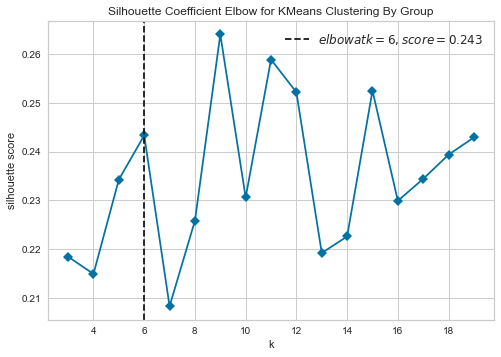

In [491]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
metric_val = 'silhouette'
visualizer = KElbowVisualizer(model, k=(3,20),title="Silhouette Coefficient Elbow for KMeans Clustering By Group", metric=metric_val,timings=False)
# , metric='calinski_harabasz','silhouette'
visualizer.fit(dfw_grouped_clustering_bygroup)
visualizer.show()
#visualizer.show(outpath="kelbow_visualizer_bygroup.png")

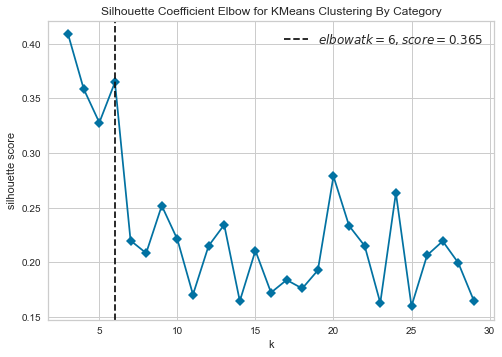

In [492]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,30),title="Silhouette Coefficient Elbow for KMeans Clustering By Category", metric=metric_val,timings=False)
visualizer.fit(dfw_grouped_clustering)
visualizer.show()
#visualizer.show(outpath="kelbow_visualizer_bycategory.png")

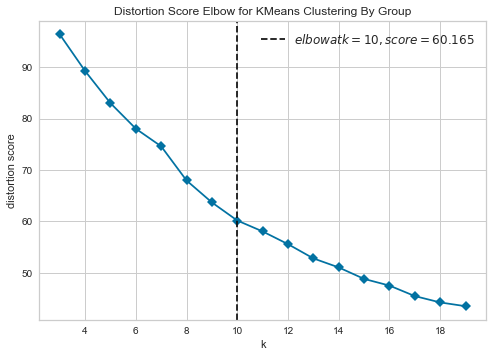

In [493]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
metric_val = 'distortion'
visualizer = KElbowVisualizer(model, k=(3,20),title="Distortion Score Elbow for KMeans Clustering By Group", metric=metric_val,timings=False)
# , metric='calinski_harabasz','silhouette'
visualizer.fit(dfw_grouped_clustering_bygroup)
visualizer.show()
#visualizer.show(outpath="kelbow_visualizer_bygroup.png")

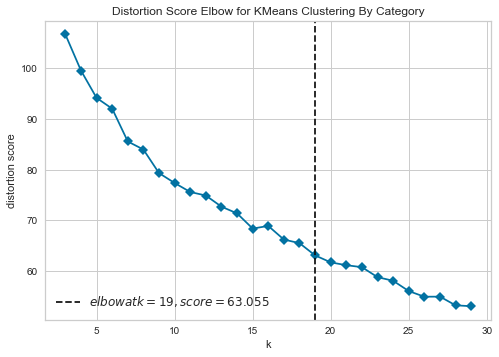

In [494]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,30),title="Distortion Score Elbow for KMeans Clustering By Category", metric=metric_val,timings=False)
visualizer.fit(dfw_grouped_clustering)
visualizer.show()
#visualizer.show(outpath="kelbow_visualizer_bycategory.png")